# Timeless Team Ranker

So here I've created a little Timeless Cup team ranker based on PvPoke data from the top 30 ranked Timeless Cup mons in PvPoke.com, as well as implementing the frequency statistics from silph.gg (this part coming soon; they don't exist yet). All of this is done in Julia, but hopefully these little notes should clarify what the ranker is doing. I recommend running everything, and then reading through this. Some sections take a little bit of time to run (though mostly the inital data collection at 15ish seconds for 30 pokemon and the first histogram which can take a few minutes).

## Getting Started

### Installing Packages

Here I'm just grabbing some of the packages I need. I'll be reading from CSVs into DataFrames and making plots and using random distributions for uncertainty. Basically, I'm just grabbing some tools that make my life easier programming.

In [57]:
using CSV, Plots, Distributions, DataFrames, JSON, Clustering
gr();

### Number of Pokemon

This is the number of pokemon that we are including in our model. Increasing this number increases the number of pokemon that are taken into consideration (in order of PvPoke rankings), but doing so will also increase computational time. 

In [58]:
const numMons = 45

45

### Reading Data

I've got a folder that contains all of the ranking CSVs from PvPoke, as well as the rankings JSON file. By changing individual CSVs in the folder, or updating the rankings file, we can easily modify the inputted data.

In [59]:
cd(homedir())
cd("TimelessData")
pvpokeRanks = JSON.parsefile("rankings-1500.json")
rankings = zeros(4, length(pvpokeRanks))

for f in filter(x -> startswith(x, pvpokeRanks[1]["speciesName"]), readdir())
    if(!(f in filter(x -> startswith(x, pvpokeRanks[1]["speciesName"] * " (Alolan)"), readdir())))
        rankings = CSV.read(f; delim=',');
        rename!(rankings, Symbol("Battle Rating")=>Symbol(pvpokeRanks[1]["speciesName"]))
        deletecols!(rankings, 3:4)
    end
end

for i = 2:numMons
    for f in filter(x -> startswith(x, pvpokeRanks[i]["speciesName"]), readdir())
        if(!(f in filter(x -> startswith(x, pvpokeRanks[i]["speciesName"] * " (Alolan)"), readdir())))
            battles = CSV.read(f; delim=',');
            deletecols!(battles, 3:4)
            deletecols!(battles, 1)
            rankings = hcat(rankings, battles, makeunique = true)
            rename!(rankings, Symbol("Battle Rating")=>Symbol(pvpokeRanks[i]["speciesName"]))
        end
    end
end

iterator = 1

for i = 1:length(pvpokeRanks)
    delete = true
    for j = 1:numMons
        if startswith(rankings[iterator, 1], pvpokeRanks[j]["speciesName"])
            delete = false
        end
    end
    if delete == true
        deleterows!(rankings, iterator)
        iterator -= 1
    end
    iterator += 1
end

names = Array{String}(undef, numMons, 1)
for i = 1:numMons
    names[i, 1] = pvpokeRanks[i]["speciesName"]
end

rank = Array{Int64}(undef, numMons, 1)

for i = 1:numMons
    rank[i, 1] = i
end

rank = hcat(names, rank)

alphabeticalRanks = sortslices(rank, by=x->x[1], dims = 1, rev = false)

rankings = hcat( alphabeticalRanks[:, 2], rankings)

rankings = sort!(rankings)

deletecols!(rankings, 1)

rankings

,Pokemon,Venusaur,Dragonair,Meganium,Charizard,Swampert,Kingdra,Lapras,Venomoth,Haunter,Ivysaur,Skuntank,Blastoise,Shelgon,Froslass,Drapion,Blaziken,Flygon,Castform (Sunny),Muk,Banette,Typhlosion,Whiscash,Torkoal,Victreebel,Gloom,Piloswine,Castform (Snowy),Charmeleon,Glalie,Politoed,Sceptile,Castform (Rainy),Beedrill,Wormadam (Plant),Dustox,Sudowoodo,Ninetales,Sealeo,Weepinbell,Spiritomb,Grotle,Cradily,Lanturn,Houndoom,Relicanth
,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,Venusaur VW+FP/SB,500,577,227,900,313,410,732,722,500,410,622,199,544,500,631,500,447,648,668,500,517,313,645,414,313,500,789,853,406,406,292,313,710,544,761,199,591,500,308,414,199,491,207,434,199
2,Dragonair DB+AT/R,422,500,534,437,632,517,571,449,500,155,306,244,492,500,679,422,406,259,520,476,255,597,197,356,356,500,734,255,521,484,360,337,445,344,496,306,178,713,406,426,352,492,461,445,488
3,Meganium VW+FP/E,772,465,500,745,240,290,408,559,500,773,641,187,484,500,500,578,229,713,686,500,607,179,416,393,550,500,551,650,566,190,572,278,908,652,518,232,662,500,324,324,480,473,194,594,187
4,Charizard FS+BB/DC,99,562,254,500,859,643,690,284,658,99,569,689,536,176,500,474,544,448,579,706,616,652,495,241,193,193,422,306,280,609,211,734,262,241,237,700,478,383,241,452,211,81,670,589,808
5,Swampert MS+HC/E,686,367,759,140,500,382,481,523,420,687,170,310,382,545,276,310,500,117,280,242,193,481,136,939,937,140,500,174,612,510,684,510,375,500,242,231,117,562,928,581,962,626,287,140,276
6,Kingdra DB+O/HP,589,482,709,356,617,500,588,535,239,574,572,400,460,617,561,339,404,230,596,452,400,560,456,608,593,545,596,213,616,447,491,400,567,500,548,671,352,606,564,576,585,486,421,178,421
7,Lapras IS+S/SB,267,428,591,309,518,411,491,466,627,531,439,453,301,348,314,786,309,500,500,679,168,372,466,629,697,386,259,312,306,549,425,572,439,276,350,536,472,511,651,475,589,439,497,386,553
8,Venomoth C+SW/PF,277,550,440,715,476,464,533,500,194,99,534,596,448,613,592,162,488,631,472,500,242,704,637,222,194,641,506,738,623,517,281,506,301,716,392,652,611,538,222,625,226,500,530,867,731
9,Haunter SC+SP/SB,500,500,500,341,579,760,372,805,500,250,188,556,536,234,530,158,768,500,448,504,464,652,372,464,494,500,631,678,413,624,382,494,265,780,611,127,413,500,464,533,494,86,372,568,372


### Colors

Just defining some colors so that things look pretty. However, there aren't cup typings this time, so its fairly arbitrary as to which typing I choose to determine the color of each mon. For Alolan Ninetales, for instance, I think of ice first, and thus that is the color of Alolan Ninetales in this model. Feel free to change these around as you feel, but given that they are primarily an aesthetic choice, I elected to not put a whole lot of thought into which color each mon gets.

In [60]:
opacity = 0.7
grass = RGBA(94/255,189/255,91/255, opacity); dragon = RGBA(14/255,104/255,184/255, opacity); dark = RGBA(86/255,86/255,99/255, opacity); normal = RGBA(153/255,159/255,161/255, opacity); fire = RGBA(254/255,163/255,84/255, opacity); ground = RGBA(212/255,141/255,91/255, opacity); poison = RGBA(193/255,98/255,212/255, opacity); rock = RGBA(208/255,196/255,142/255, opacity); ghost = RGBA(89/255,107/255,181/255, opacity); psychic = RGBA(245/255,126/255,121/255, opacity); ice = RGBA(120/255,212/255,192/255, opacity); water = RGBA(86/255,158/255,222/255, opacity); fighting = RGBA(213/255,63/255,91/255, opacity); steel = RGBA(82/255,142/255,160/255, opacity); fairy = RGBA(240/255,152/255,228/255, opacity); flying = RGBA(148/255,171/255,225/255, opacity); bug = RGBA(158/255,195/255,49/255, opacity); electric = RGBA(246/255,215/255,75/255, opacity);

### Restrictions

Here I am adding a function to see if a particular three mon team is restricted, that is, if it contains more than one starter.

In [61]:
const limitedMons = ["Bulbasaur" "Ivysaur" "Venusaur" "Charmander" "Charmeleon" "Charizard" "Squirtle" "Warturtle" "Blastoise"
                    "Chikorita" "Bayleef" "Meganium" "Cyndaquil" "Quilava" "Typhlosion" "Totodile" "Croconaw" "Feraligatr"
                    "Treecko" "Grovyle" "Sceptile" "Torchic" "Combusken" "Blaziken" "Mudkip" "Marshtomp" "Swampert"
                    "Turtwig" "Grotle" "Torterra" "Chimchar" "Monferno" "Infernape" "Piplup" "Prinplup" "Empoleon"]
function isRestricted(mon1, mon2, mon3)
    numLimited = 0
    if in(pvpokeRanks[mon1]["speciesName"], limitedMons)
        numLimited += 1 
    end
    if in(pvpokeRanks[mon2]["speciesName"], limitedMons)
        numLimited += 1
        if numLimited > 1
            return true
        end
    end
    if in(pvpokeRanks[mon3]["speciesName"], limitedMons)
        numLimited += 1
        if numLimited > 1
            return true
        end
    end
    return false
end

isRestricted (generic function with 1 method)

### Team Numbers

Here I'm mapping the 3 mon teams to a number, such that each team has its own unique number from 1 to 12180 ($\frac{30 \cdot 29 \cdot 28}{2}$)

In [62]:
teamNumberVar = zeros(numMons, numMons, numMons)
i = 1
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        teamNumberVar[mon1, mon2, mon3] = Int(i)
        i += 1
    end
end
const teamNumber = teamNumberVar;
const numTeams = i - 1;
numTeams

36465

### Setting Up the Tables

I'm grabbing just the data I need and putting it in a constant (for SPEED) matrix, and also defining a matrix to store the outputs in.

In [63]:
# clean up ranking data for simulation
# Defining as constant for SPEED
const ranks = [rankings[i, j] for i = 1:numMons, j = 2:(numMons + 1)];
teamBattles = zeros(numTeams, numTeams);
#teamBattlesWeighted = zeros(numTeams, numTeams);

## The Model

### Assumptions

So, we all know assumptions are bad. But in data science, sometimes our models need to be simplified so we can work with the information that we have in a reasonable time scale. Therefore, I have made some simplifying assumptions for the model of PvP battles, and will add some uncertainty to account for some of the differences between this model and the reality of PvP battling.

*   **No Switching:** Switching is a weird mechanic for which the timing is never consistent, when and if you should use it in scenario X is hotly debated, and then your opponent switches, which is a lot of variability. As will be a pretty common motivator among all of these reasons, if I have the home team switch perfectly, it involves some knowledge of the opposing team that you don't have in that situation. All of this to say, for this model, nobody switches because it makes everything work better, my life easier, and doesn't run the risk of having the model make decisions better than any player could be expected to. 

*   **Each Mon Gets One Shield:** I know, I know. Doesn't that add up to three shields? Well, yeah. But again, shielding choices add in some variability, and perfect use involves some knowledge of the opposing team that you don't have in that situation. Plus, then one data set is needed, the 1-1 shield matchups from PvPoke, which I believe also implicitly have the shield used on the first charged move. 

*   **Players Play Perfectly Otherwise:** Whoa. In all that avoidance of perfection, now I want my model to be perfect? Well, for one, this is just based on the assumptions in PvPoke. For two, I stand by that decision, as its perfection that's acheivable by the knowledge a player has in a particular situation. You may not know when to shield or switch, but you do probably know that you want an excellent charged move and to tap out fast moves (also I'm assuming everyone is on 1.57 or higher, because I do not want to deal with under or overtapping). Also, this model assumes the ideal moveset for each mon (though you can change that by changing the CSVs.

*   **Putting a Mon in the Second Position is the Same as Putting it in the Third:** I think this assumption is generally accurate. I think I've seen arguments for putting the fast switch in the third position, but I'm also assuming players play perfectly and there's no switching, so I genuinely think this doesn't affect the model, but I'm including it anyway.

*   **Mons Appear Uniformly Among the Top 30 Mons:** Sorry, Spoink fans. This is to keep the amount of data this processes to a reasonable amount. There is another version of this model that uses the Silph distribution instead, however, Silph data does not exist for the Ferocious Cup yet.

*   **Score Above 1500 is a Win:** This is based on the PvPoke battle score, and since there are three battles, its out of 3000 instead of 1000. Scoring is explained more below, but this is the assumption of what we do with that score. 

None of these assumptions are set in stone. In fact, if you have a way to change them and think that that's more useful to you, 1) go ahead and 2) let me know how you did it. 

### Scoring

I know, this section is already too long, just show you the data. But here's what the data means. Each PvPoke battle is given a score of 0-1000 with 500 representing a tie, and above that being a win, below that a loss. The score for the three-mon battle is adding those three scores together. But, that depends on which matchups you see. The lead pokemon always face each other. If your lead wins, you get the favorable matchups (because your opponent had to put in a pokemon and you can counter it), if your lead loses, you get the less favorable matchups. And, as stated above, over 1500 is a win.

In [64]:
function individual_battle_verbose(home1,home2,home3,away1,away2,away3,rankings)
    
                 score  = rankings[away1, home1]
    secondBattleResult1 = rankings[away2, home2]
    secondBattleResult2 = rankings[away3, home2]
    thirdBattleResult1  = rankings[away2, home3]
    thirdBattleResult2  = rankings[away3, home3]

    if score > 500 
        score += max(secondBattleResult2 + thirdBattleResult1, secondBattleResult1 + thirdBattleResult2) 
    elseif score < 500 
        score += min(secondBattleResult2 + thirdBattleResult1, secondBattleResult1 + thirdBattleResult2) 
    else
        score += (secondBattleResult2 + thirdBattleResult1 + secondBattleResult1 + thirdBattleResult2)/2.0 
    end 
    
    return score
    
end;

### Testing

The timing stuff is mostly for me, to make sure things can run in a reasonable time. But they exist and they're here in case you're curious

In [65]:
# Run once to compile, run again to test speed (with different input so no cheating)
individual_battle_verbose(1,2,3,4,5,6,ranks)
@time score = individual_battle_verbose(1,2,7,4,5,6,ranks)

  0.000002 seconds (6 allocations: 224 bytes)


1054

### Testing a Team

This function does all possible teams against a certain team. And there are two versions, depending on if you want verbose output.

In [66]:
function run_away_teams_verbose(home1,home2,home3,ranks)

    for away1 = 1:numMons , away2 = 1:(numMons - 1) , away3 = (away2 + 1):numMons

        if away1 != away2 && away1 != away3 && !isRestricted(away1, away2, away3)

            # Do the battle!
            # Use the function we wrote above
            score = individual_battle_verbose(home1,home2,home3,away1,away2,away3,ranks)
            teamBattles[Int(teamNumber[home1,home2,home3]), Int(teamNumber[away1,away2,away3])] = score
        end
    end
end;

In [67]:
# Run once to compile, run again to test speed (with different input so no cheating)
run_away_teams_verbose(1,2,6,ranks)
@time run_away_teams_verbose(1,2,7,ranks)

  0.024828 seconds (72.42 k allocations: 1.105 MiB)


In [68]:
function run_home_teams_verbose(ranks)
    
    for home1 = 1:numMons , home2 = 1:(numMons - 1) , home3 = (home2 + 1):numMons 
        if home1 != home2 && home1 != home3 && !isRestricted(home1, home2, home3)
            run_away_teams_verbose(home1,home2,home3,ranks)
        end 
    end 
end;

In [69]:
# Run once to compile, run again to test speed 
run_home_teams_verbose(ranks)
@time run_home_teams_verbose(ranks);

849.859227 seconds (3.95 G allocations: 58.865 GiB, 0.79% gc time)


In [70]:
teamBattles

36465×36465 Array{Float64,2}:
 1499.5  1428.0  1515.5  1638.5  1568.5  …  2268.0  1885.0  2128.0  2159.0
 1570.5  1495.0  1577.0  1471.5  1662.0     2060.0  1898.0  1920.0  1951.0
 1483.0  1421.5  1499.5  1627.0  1553.5     2127.0  1838.0  1854.0  1823.0
 1360.5  1527.5  1372.0  1500.0  1752.0     1878.0  2251.0  2267.0  1981.0
 1430.0  1336.5  1445.0  1247.0  1499.5     2023.0  1853.0  1869.0  1888.0
 1467.0  1360.5  1495.0  1514.0  1548.0  …  2031.0  1988.0  1891.0  2035.0
 1549.5  1388.0  1581.5  1367.0  1738.5     1895.0  2231.0  2247.0  1732.0
 1611.0  1460.5  1660.5  1604.5  1705.5     2042.0  1890.0  1906.0  1899.0
 1396.0  1321.5  1472.0  1587.0  1716.0     2296.0  2171.0  2187.0  2187.0
 1235.5  1343.5  1470.0  1379.5  1479.0     2102.0  1686.0  1751.0  1782.0
 1549.0  1474.0  1521.0  1484.0  1622.0  …  2081.0  1934.0  1950.0  1798.0
 1455.0  1541.5  1513.0  1490.0  1562.0     1904.0  2228.0  2244.0  2007.0
 1569.5  1448.5  1675.5  1624.5  1721.0     2340.0  2045.0  2200.0  22

### Summary Stats

Here I'm going to save the summary stats for every team, where my summary stats are the number of wins, and the mean, variance, skewness, and kurtosis of the scores. 

In [71]:
summaryStats = zeros(numTeams, 8)
i = 1
p = x -> (x > 1500.0)
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        team = teamBattles[Int(teamNumber[Int(mon1), Int(mon2), Int(mon3)]),:]
        numWins = count(p,team)
        summaryStats[i, :] = [numWins mean(team) var(team) skewness(team) kurtosis(team) mon1 mon2 mon3]
        i += 1
    end
end        

## Number of Wins

Here we've got the information related to the number of wins. Below is a histogram of the number of teams vs their number of wins, a sorted list that shows the best and worst teams by number of wins, and a histogram comparing the scores of the best and worst teams by number of wins.

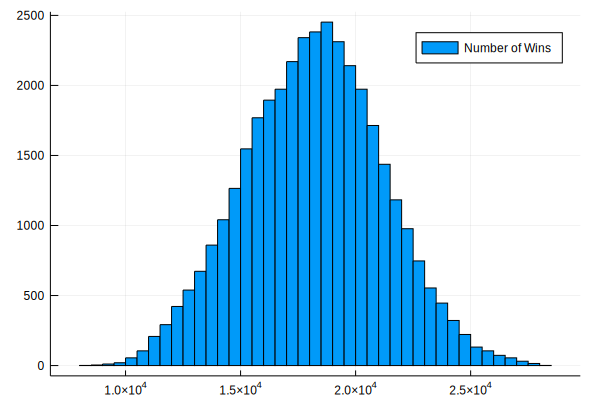

In [133]:
histogram(summaryStats[:, 1], label = "Number of Wins")

In [73]:
sumStatsNumWins = sortslices(summaryStats, by=x->x[1], dims = 1, rev = true)

for i = 1:numTeams
    sumStatsNumWins[i, 1] /= (numTeams / 100.0)
end

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = pvpokeRanks[Int(sumStatsNumWins[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = pvpokeRanks[Int(sumStatsNumWins[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = pvpokeRanks[Int(sumStatsNumWins[i, 8])]["speciesName"]
end

sumStatsNumWins = hcat(sumStatsNumWins, names1)
sumStatsNumWins = hcat(sumStatsNumWins, names2)
sumStatsNumWins = hcat(sumStatsNumWins, names3)

sumStatsNumWins = DataFrame(sumStatsNumWins)

rename!(sumStatsNumWins, Symbol("x1")=>Symbol("Win %"))
rename!(sumStatsNumWins, Symbol("x2")=>Symbol("Avg Score"))
rename!(sumStatsNumWins, Symbol("x3")=>Symbol("Avg Variance"))
rename!(sumStatsNumWins, Symbol("x4")=>Symbol("Avg Skew"))
rename!(sumStatsNumWins, Symbol("x5")=>Symbol("Avg Kurt"))
rename!(sumStatsNumWins, Symbol("x6")=>Symbol("Rank Mon 1"))
rename!(sumStatsNumWins, Symbol("x7")=>Symbol("Rank Mon 2"))
rename!(sumStatsNumWins, Symbol("x8")=>Symbol("Rank Mon 3"))
rename!(sumStatsNumWins, Symbol("x9")=>Symbol("Mon 1"))
rename!(sumStatsNumWins, Symbol("x10")=>Symbol("Mon 2"))
rename!(sumStatsNumWins, Symbol("x11")=>Symbol("Mon 3"))

,Win %,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,76.8929,1719.06,1.10096e5,-0.450756,0.149497,2.0,5.0,9.0,Dragonair,Swampert,Haunter
2,76.7366,1695.06,70375.8,-0.27595,-0.20201,2.0,7.0,20.0,Dragonair,Lapras,Banette
3,76.6159,1725.05,99749.6,-0.51737,-0.0458774,2.0,5.0,7.0,Dragonair,Swampert,Lapras
4,76.3691,1721.88,97283.7,-0.340948,-0.269123,2.0,4.0,20.0,Dragonair,Charizard,Banette
5,76.339,1691.12,85885.9,-0.544382,0.192334,2.0,7.0,22.0,Dragonair,Lapras,Whiscash
6,76.2128,1694.64,99462.7,-0.504259,0.304305,2.0,9.0,22.0,Dragonair,Haunter,Whiscash
7,76.0071,1674.63,75719.8,-0.245434,0.117152,2.0,9.0,20.0,Dragonair,Haunter,Banette
8,75.9962,1707.33,1.08209e5,-0.601585,0.122403,2.0,5.0,15.0,Dragonair,Swampert,Drapion
9,75.9002,1731.45,1.09189e5,-0.426449,-0.148006,2.0,5.0,20.0,Dragonair,Swampert,Banette


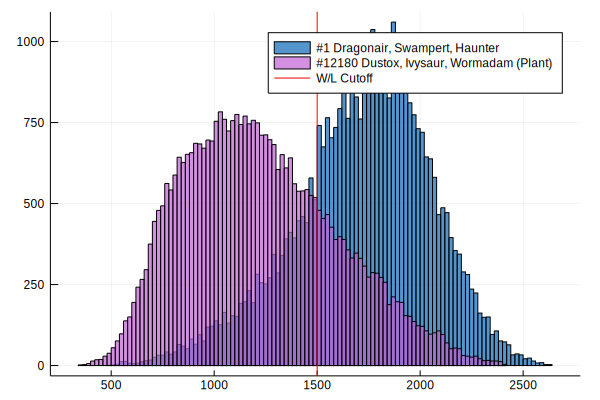

In [134]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsNumWins[1, 6]), Int(sumStatsNumWins[1, 7]), Int(sumStatsNumWins[1, 8])]),:], bins = 100, color = dragon, label = "#1 " * sumStatsNumWins[1, 9] * ", " * sumStatsNumWins[1, 10] * ", " * sumStatsNumWins[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsNumWins[numTeams, 6]), Int(sumStatsNumWins[numTeams, 7]), Int(sumStatsNumWins[numTeams, 8])]),:], bins = 100, color = poison, label = "#12180 " * sumStatsNumWins[numTeams, 9] * ", " * sumStatsNumWins[numTeams, 10] * ", " * sumStatsNumWins[numTeams, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

Here we've got the number of wins on average in every team a particular pokemon is a part of and rank them below, again showing the best and worst.

In [75]:
avgNumOfWins = zeros(numMons, 2)
i = 1
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        avgNumOfWins[mon1, 1] += summaryStats[i, 1]
        avgNumOfWins[mon2, 1] += summaryStats[i, 1]
        avgNumOfWins[mon3, 1] += summaryStats[i, 1]
        i += 1
    end
end
for i = 1:numMons
    avgNumOfWins[i, 2] = i
    divisor = 0.0
    for mon2 = 1:numMons, mon3 = mon2 + 1:numMons
        if(teamNumber[i, mon2, mon3] > 0)
           divisor += 1.0
        end
        if(teamNumber[mon2, i, mon3] > 0)
           divisor += 1.0
        end
        if(teamNumber[mon2, mon3, i] > 0)
           divisor += 1.0
        end
    end
    avgNumOfWins[i, 1] /= (divisor * numTeams / 100.0)
end

avgNumOfWinsSorted = sortslices(avgNumOfWins, by=x->x[1], dims = 1, rev = true)

nameNumWins = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameNumWins[i, 1] = pvpokeRanks[Int(avgNumOfWinsSorted[i, 2])]["speciesName"]
end

avgNumOfWinsSorted = hcat(avgNumOfWinsSorted, nameNumWins)

avgNumOfWinsSorted = DataFrame(avgNumOfWinsSorted)

rename!(avgNumOfWinsSorted, Symbol("x1")=>Symbol("Win %"))
rename!(avgNumOfWinsSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgNumOfWinsSorted, Symbol("x3")=>Symbol("Name"))

,Win %,Rank,Name
,Any,Any,Any
1,88.025,2.0,Dragonair
2,86.7887,5.0,Swampert
3,84.3974,22.0,Whiscash
4,84.0604,20.0,Banette
5,83.2874,7.0,Lapras
6,82.7434,30.0,Politoed
7,81.0811,45.0,Relicanth
8,80.5495,4.0,Charizard
9,80.0922,32.0,Castform (Rainy)


Here I've plotted the PvPoke ranking compared to the average number of wins. I think its not necessarily a surprise that there's not a perfect correlation here (you don't put in the top 6 ranked mons generally), but there is a pretty clear negative slope here. The big spike I think is Lickilicky.

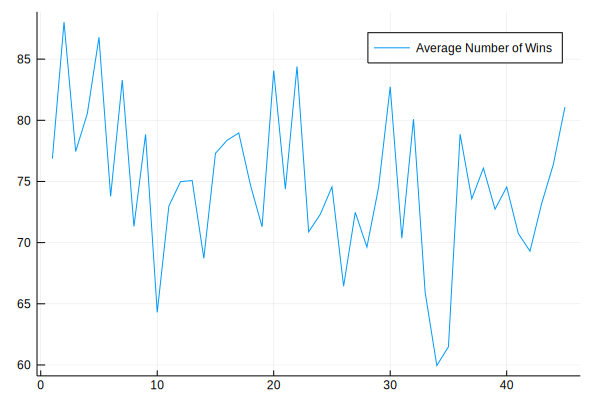

In [135]:
plot(1:numMons, avgNumOfWins[:, 1], label = "Average Number of Wins")

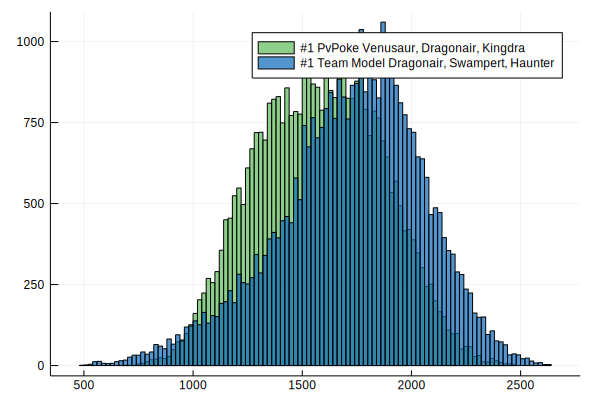

In [136]:
histogram(teamBattles[Int(teamNumber[1, 2, 6]),:], bins = 100, color = grass, label = "#1 PvPoke Venusaur, Dragonair, Kingdra")
histogram!(teamBattles[Int(teamNumber[Int(sumStatsNumWins[1, 6]), Int(sumStatsNumWins[1, 7]), Int(sumStatsNumWins[1, 8])]),:], bins = 100, color = dragon, label = "#1 Team Model " * sumStatsNumWins[1, 9] * ", " * sumStatsNumWins[1, 10] * ", " * sumStatsNumWins[1, 11])

## Average Score

Here we've got the information related to the average. Below is a histogram of the number of teams vs their average, a sorted list that shows the best and worst teams by average score, and a histogram comparing the scores of the best and worst teams by average score. Not that there are minor differences between the average score statistics and the number of wins. I generally consider number of wins to be a more useful statistic (as it doesn't necessarily matter to me how much I win by as long as I win), but I could see arguments for using this particular statistic instead.

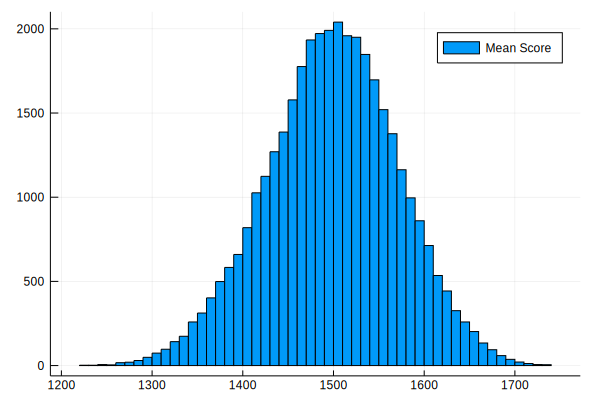

In [137]:
histogram(summaryStats[:, 2], label = "Mean Score")

In [79]:
sumStatsAvgScore = sortslices(summaryStats, by=x->x[2], dims = 1, rev = true)

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = pvpokeRanks[Int(sumStatsAvgScore[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = pvpokeRanks[Int(sumStatsAvgScore[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = pvpokeRanks[Int(sumStatsAvgScore[i, 8])]["speciesName"]
end

sumStatsAvgScore = hcat(sumStatsAvgScore, names1)
sumStatsAvgScore = hcat(sumStatsAvgScore, names2)
sumStatsAvgScore = hcat(sumStatsAvgScore, names3)

sumStatsAvgScore = DataFrame(sumStatsAvgScore)

rename!(sumStatsAvgScore, Symbol("x1")=>Symbol("Num of Wins"))
rename!(sumStatsAvgScore, Symbol("x2")=>Symbol("Avg Score"))
rename!(sumStatsAvgScore, Symbol("x3")=>Symbol("Avg Variance"))
rename!(sumStatsAvgScore, Symbol("x4")=>Symbol("Avg Skew"))
rename!(sumStatsAvgScore, Symbol("x5")=>Symbol("Avg Kurt"))
rename!(sumStatsAvgScore, Symbol("x6")=>Symbol("Rank Mon 1"))
rename!(sumStatsAvgScore, Symbol("x7")=>Symbol("Rank Mon 2"))
rename!(sumStatsAvgScore, Symbol("x8")=>Symbol("Rank Mon 3"))
rename!(sumStatsAvgScore, Symbol("x9")=>Symbol("Mon 1"))
rename!(sumStatsAvgScore, Symbol("x10")=>Symbol("Mon 2"))
rename!(sumStatsAvgScore, Symbol("x11")=>Symbol("Mon 3"))

,Num of Wins,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,27118.0,1732.65,1.38958e5,-0.339139,-0.165235,2.0,5.0,24.0,Dragonair,Swampert,Victreebel
2,27677.0,1731.45,1.09189e5,-0.426449,-0.148006,2.0,5.0,20.0,Dragonair,Swampert,Banette
3,27496.0,1731.44,1.13897e5,-0.224031,-0.396699,2.0,4.0,17.0,Dragonair,Charizard,Flygon
4,27565.0,1730.81,1.16861e5,-0.499086,-0.00806153,2.0,4.0,22.0,Dragonair,Charizard,Whiscash
5,27364.0,1730.03,1.34687e5,-0.397882,-0.0778172,2.0,5.0,25.0,Dragonair,Swampert,Gloom
6,26942.0,1728.78,1.39674e5,-0.328795,-0.189155,2.0,5.0,39.0,Dragonair,Swampert,Weepinbell
7,27938.0,1725.05,99749.6,-0.51737,-0.0458774,2.0,5.0,7.0,Dragonair,Swampert,Lapras
8,27663.0,1722.34,112346.0,-0.330152,-0.0192731,2.0,5.0,17.0,Dragonair,Swampert,Flygon
9,27848.0,1721.88,97283.7,-0.340948,-0.269123,2.0,4.0,20.0,Dragonair,Charizard,Banette


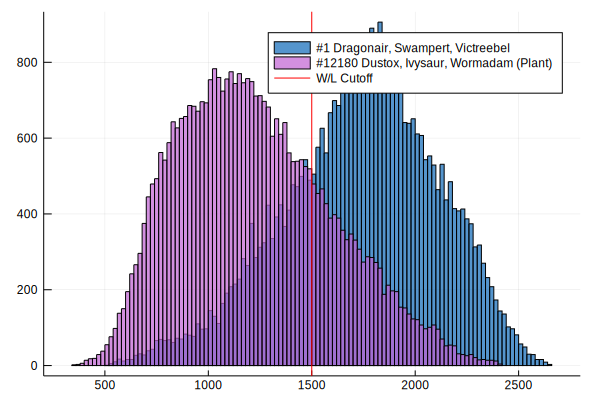

In [138]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsAvgScore[1, 6]), Int(sumStatsAvgScore[1, 7]), Int(sumStatsAvgScore[1, 8])]),:], bins = 100, color = dragon, label = "#1 " * sumStatsAvgScore[1, 9] * ", " * sumStatsAvgScore[1, 10] * ", " * sumStatsAvgScore[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsAvgScore[numTeams, 6]), Int(sumStatsAvgScore[numTeams, 7]), Int(sumStatsAvgScore[numTeams, 8])]),:], bins = 100, color = poison, label = "#12180 " * sumStatsAvgScore[numTeams, 9] * ", " * sumStatsAvgScore[numTeams, 10] * ", " * sumStatsAvgScore[numTeams, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

In [81]:
avgScore = zeros(numMons, 2)
i = 1
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        avgScore[mon1, 1] += summaryStats[i, 2]
        avgScore[mon2, 1] += summaryStats[i, 2]
        avgScore[mon3, 1] += summaryStats[i, 2]
        i += 1
    end
end
for i = 1:numMons
    avgScore[i, 2] = i
    divisor = 0.0
    for mon2 = 1:numMons, mon3 = mon2 + 1:numMons
        if(teamNumber[i, mon2, mon3] > 0)
           divisor += 1.0
        end
        if(teamNumber[mon2, i, mon3] > 0)
           divisor += 1.0
        end
        if(teamNumber[mon2, mon3, i] > 0)
           divisor += 1.0
        end
    end
    avgScore[i, 1] /= (divisor * numTeams)
end
#avgScore[:, 1] ./ (numTeams / (numMons / 3.0))

avgScoreSorted = sortslices(avgScore, by=x->x[1], dims = 1, rev = true)

nameAvgScore = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameAvgScore[i, 1] = pvpokeRanks[Int(avgScoreSorted[i, 2])]["speciesName"]
end

avgScoreSorted = hcat(avgScoreSorted, nameAvgScore)

avgScoreSorted = DataFrame(avgScoreSorted)

rename!(avgScoreSorted, Symbol("x1")=>Symbol("Avg Score"))
rename!(avgScoreSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgScoreSorted, Symbol("x3")=>Symbol("Name"))

,Avg Score,Rank,Name
,Any,Any,Any
1,0.0648478,2.0,Dragonair
2,0.0647382,5.0,Swampert
3,0.0640972,20.0,Banette
4,0.0637777,22.0,Whiscash
5,0.0637718,7.0,Lapras
6,0.0635999,4.0,Charizard
7,0.0634683,17.0,Flygon
8,0.0634107,30.0,Politoed
9,0.0632247,45.0,Relicanth


Again, there isn't a strong correlation with the average score to the PvPoke ranking, but that is to be expected. Also, average score is strongly correlated with the number of wins, which is also to be expected. So this particular statistic is not the same as number of wins, or even leads to the same conclusion, but they are correlated.

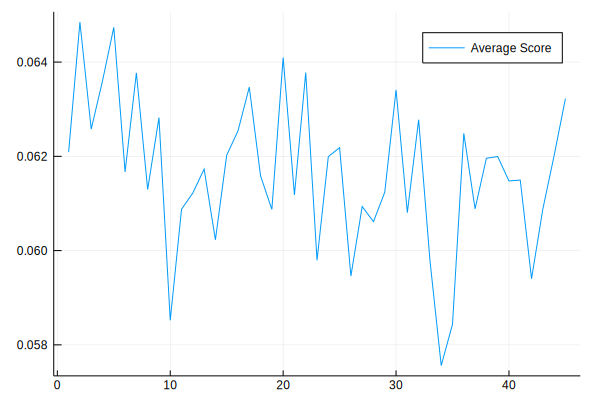

In [139]:
plot(1:numMons, avgScore[:, 1], label = "Average Score")

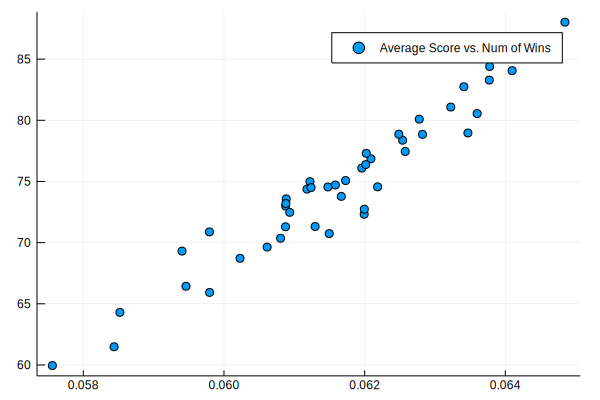

In [140]:
plot(avgScore[:, 1], avgNumOfWins[:, 1], seriestype=:scatter, label = "Average Score vs. Num of Wins")

## Variance

Here's where the team decision making from this data begins to be less obvious. If you're not interested in Variance, Skewness or Kurtosis, I encourage you to scroll down past these sections. I do include these sections on higher order moments in part because I find them interesting, but also these might be useful for someone somewhere, and as such, I included them. 

Variance is a measure of how wide (or thin) the distribution is. Teams with a higher variance have scores that are more spread out, while teams with lower variance have scores that stay closer to their mean value. This is independent of the mean (as this variance is a centered moment), and thus one team is not necessarily better than the other by this metric, just more or less spread out.

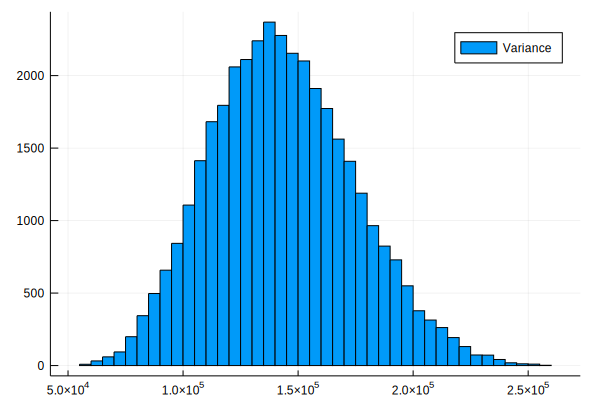

In [141]:
histogram(summaryStats[:, 3], label = "Variance")

In [85]:
sumStatsVariance = sortslices(summaryStats, by=x->x[3], dims = 1, rev = true)

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = pvpokeRanks[Int(sumStatsVariance[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = pvpokeRanks[Int(sumStatsVariance[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = pvpokeRanks[Int(sumStatsVariance[i, 8])]["speciesName"]
end

sumStatsVariance = hcat(sumStatsVariance, names1)
sumStatsVariance = hcat(sumStatsVariance, names2)
sumStatsVariance = hcat(sumStatsVariance, names3)

sumStatsVariance = DataFrame(sumStatsVariance)

rename!(sumStatsVariance, Symbol("x1")=>Symbol("Num of Wins")); rename!(sumStatsVariance, Symbol("x2")=>Symbol("Avg Score")); rename!(sumStatsVariance, Symbol("x3")=>Symbol("Avg Variance")); rename!(sumStatsVariance, Symbol("x4")=>Symbol("Avg Skew")); rename!(sumStatsVariance, Symbol("x5")=>Symbol("Avg Kurt")); rename!(sumStatsVariance, Symbol("x6")=>Symbol("Rank Mon 1")); rename!(sumStatsVariance, Symbol("x7")=>Symbol("Rank Mon 2")); rename!(sumStatsVariance, Symbol("x8")=>Symbol("Rank Mon 3")); rename!(sumStatsVariance, Symbol("x9")=>Symbol("Mon 1")); rename!(sumStatsVariance, Symbol("x10")=>Symbol("Mon 2")); rename!(sumStatsVariance, Symbol("x11")=>Symbol("Mon 3"))

,Num of Wins,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,16598.0,1501.06,2.56292e5,0.220853,-1.04732,28.0,24.0,45.0,Charmeleon,Victreebel,Relicanth
2,20826.0,1570.16,2.55724e5,-0.120186,-1.05575,45.0,28.0,39.0,Relicanth,Charmeleon,Weepinbell
3,16530.0,1498.74,2.54756e5,0.196423,-1.06983,28.0,25.0,45.0,Charmeleon,Gloom,Relicanth
4,16224.0,1483.3,2.54687e5,0.233977,-1.05268,28.0,24.0,36.0,Charmeleon,Victreebel,Sudowoodo
5,16577.0,1501.55,2.54677e5,0.216471,-1.02838,28.0,39.0,45.0,Charmeleon,Weepinbell,Relicanth
6,16240.0,1483.49,253775.0,0.226734,-1.03941,28.0,36.0,39.0,Charmeleon,Sudowoodo,Weepinbell
7,20398.0,1549.19,2.53398e5,-0.0993211,-1.06261,36.0,28.0,39.0,Sudowoodo,Charmeleon,Weepinbell
8,20656.0,1569.25,2.52973e5,-0.102567,-1.03909,45.0,24.0,28.0,Relicanth,Victreebel,Charmeleon
9,16228.0,1481.15,2.52693e5,0.208483,-1.07057,28.0,25.0,36.0,Charmeleon,Gloom,Sudowoodo


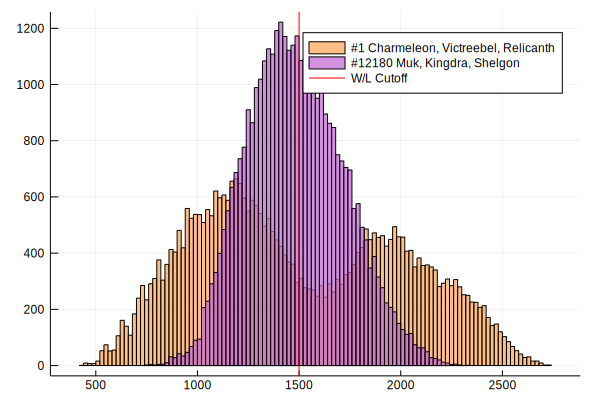

In [165]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsVariance[1, 6]), Int(sumStatsVariance[1, 7]), Int(sumStatsVariance[1, 8])]),:], bins = 200, color = fire, label = "#1 " * sumStatsVariance[1, 9] * ", " * sumStatsVariance[1, 10] * ", " * sumStatsVariance[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsVariance[numTeams, 6]), Int(sumStatsVariance[numTeams, 7]), Int(sumStatsVariance[numTeams, 8])]),:], bins = 100, color = poison, label = "#12180 " * sumStatsVariance[numTeams, 9] * ", " * sumStatsVariance[numTeams, 10] * ", " * sumStatsVariance[numTeams, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

In [87]:
avgVar = zeros(numMons, 2)
i = 1
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        avgVar[mon1, 1] += summaryStats[i, 3]
        avgVar[mon2, 1] += summaryStats[i, 3]
        avgVar[mon3, 1] += summaryStats[i, 3]
        i += 1
    end
end
for i = 1:numMons
    avgVar[i, 2] = i
end
avgVar[:, 1] ./ (numTeams / (numMons / 3.0))

avgVarSorted = sortslices(avgVar, by=x->x[1], dims = 1, rev = true)

nameAvgVar = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameAvgVar[i, 1] = pvpokeRanks[Int(avgVarSorted[i, 2])]["speciesName"]
end

avgVarSorted = hcat(avgVarSorted, nameAvgVar)

avgVarSorted = DataFrame(avgVarSorted)

rename!(avgVarSorted, Symbol("x1")=>Symbol("Avg Variance"))
rename!(avgVarSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgVarSorted, Symbol("x3")=>Symbol("Name"))

,Avg Variance,Rank,Name
,Any,Any,Any
1,4.61125e8,45.0,Relicanth
2,4.55287e8,36.0,Sudowoodo
3,4.53449e8,39.0,Weepinbell
4,4.52479e8,24.0,Victreebel
5,4.42601e8,25.0,Gloom
6,4.36126e8,44.0,Houndoom
7,4.20573e8,18.0,Castform (Sunny)
8,4.17986e8,34.0,Wormadam (Plant)
9,4.0746e8,22.0,Whiscash


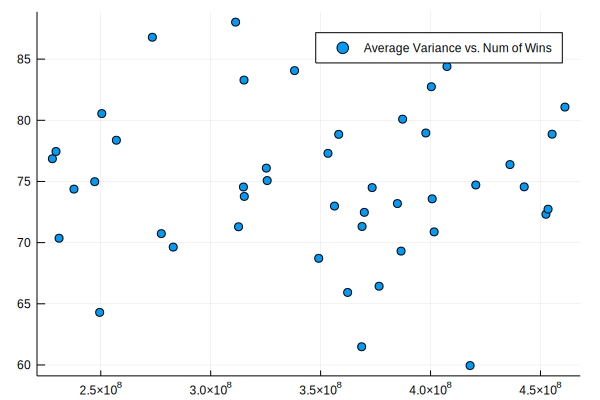

In [143]:
plot(avgVar[:, 1], avgNumOfWins[:, 1], seriestype=:scatter, label = "Average Variance vs. Num of Wins")

## Skewness

Skewness is a little different in that on either end its not more skewed and less skewed, but rather skewed in one direction or the other. This is sort of similar to average score in what it ends up being, but the teams are not as good by that metric, because its specifically looking for skewness.

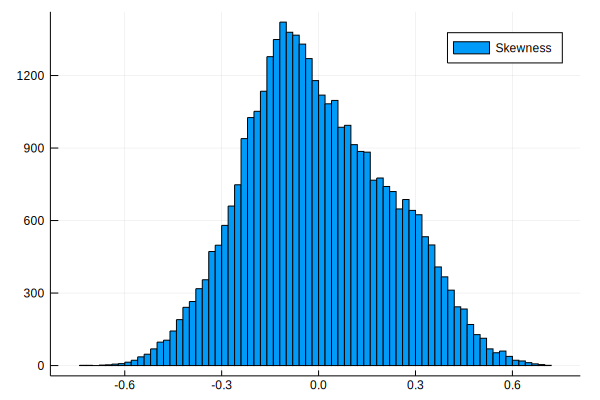

In [144]:
histogram(summaryStats[:, 4], label = "Skewness")

In [90]:
sumStatsSkewness = sortslices(summaryStats, by=x->x[4], dims = 1, rev = false)

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = pvpokeRanks[Int(sumStatsSkewness[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = pvpokeRanks[Int(sumStatsSkewness[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = pvpokeRanks[Int(sumStatsSkewness[i, 8])]["speciesName"]
end

sumStatsSkewness = hcat(sumStatsSkewness, names1)
sumStatsSkewness = hcat(sumStatsSkewness, names2)
sumStatsSkewness = hcat(sumStatsSkewness, names3)

sumStatsSkewness = DataFrame(sumStatsSkewness)

rename!(sumStatsSkewness, Symbol("x1")=>Symbol("Num of Wins")); rename!(sumStatsSkewness, Symbol("x2")=>Symbol("Avg Score")); rename!(sumStatsSkewness, Symbol("x3")=>Symbol("Avg Variance")); rename!(sumStatsSkewness, Symbol("x4")=>Symbol("Avg Skew")); rename!(sumStatsSkewness, Symbol("x5")=>Symbol("Avg Kurt")); rename!(sumStatsSkewness, Symbol("x6")=>Symbol("Rank Mon 1")); rename!(sumStatsSkewness, Symbol("x7")=>Symbol("Rank Mon 2")); rename!(sumStatsSkewness, Symbol("x8")=>Symbol("Rank Mon 3")); rename!(sumStatsSkewness, Symbol("x9")=>Symbol("Mon 1")); rename!(sumStatsSkewness, Symbol("x10")=>Symbol("Mon 2")); rename!(sumStatsSkewness, Symbol("x11")=>Symbol("Mon 3"))

,Num of Wins,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,25640.0,1623.37,1.03516e5,-0.732971,0.454787,2.0,22.0,42.0,Dragonair,Whiscash,Cradily
2,27077.0,1656.49,84569.6,-0.706471,0.463672,2.0,19.0,22.0,Dragonair,Muk,Whiscash
3,25861.0,1655.16,1.16397e5,-0.671202,0.265493,2.0,5.0,42.0,Dragonair,Swampert,Cradily
4,27481.0,1688.82,97018.2,-0.661953,0.223251,2.0,5.0,19.0,Dragonair,Swampert,Muk
5,26577.0,1653.93,96330.7,-0.653523,0.412366,2.0,11.0,22.0,Dragonair,Skuntank,Whiscash
6,25224.0,1631.07,1.10036e5,-0.651578,0.210006,2.0,22.0,23.0,Dragonair,Whiscash,Torkoal
7,27378.0,1693.72,1.0315e5,-0.643767,0.254803,2.0,1.0,22.0,Dragonair,Venusaur,Whiscash
8,26312.0,1660.89,1.10134e5,-0.637239,0.25585,2.0,22.0,37.0,Dragonair,Whiscash,Ninetales
9,27263.0,1661.1,83094.6,-0.62772,0.43748,2.0,13.0,22.0,Dragonair,Shelgon,Whiscash


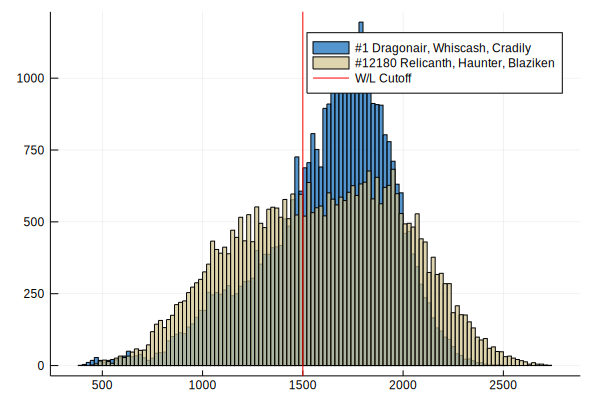

In [164]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsSkewness[1, 6]), Int(sumStatsSkewness[1, 7]), Int(sumStatsSkewness[1, 8])]),:], bins = 100, color = dragon, label = "#1 " * sumStatsSkewness[1, 9] * ", " * sumStatsSkewness[1, 10] * ", " * sumStatsSkewness[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsSkewness[12180, 6]), Int(sumStatsSkewness[12180, 7]), Int(sumStatsSkewness[12180, 8])]),:], bins = 200, color = rock, label = "#12180 " * sumStatsSkewness[12180, 9] * ", " * sumStatsSkewness[12180, 10] * ", " * sumStatsSkewness[12180, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

In [92]:
avgSkew = zeros(numMons, 2)
i = 1
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        avgSkew[mon1, 1] += summaryStats[i, 4]
        avgSkew[mon2, 1] += summaryStats[i, 4]
        avgSkew[mon3, 1] += summaryStats[i, 4]
        i += 1
    end
end
for i = 1:numMons
    avgSkew[i, 2] = i
end
avgSkew[:, 1] ./ (numTeams / (numMons / 3.0))

avgSkewSorted = sortslices(avgSkew, by=x->x[1], dims = 1, rev = false)

nameAvgSkew = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameAvgSkew[i, 1] = pvpokeRanks[Int(avgSkewSorted[i, 2])]["speciesName"]
end

avgSkewSorted = hcat(avgSkewSorted, nameAvgSkew)

avgSkewSorted = DataFrame(avgSkewSorted)

rename!(avgSkewSorted, Symbol("x1")=>Symbol("Avg Skewness"))
rename!(avgSkewSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgSkewSorted, Symbol("x3")=>Symbol("Name"))

,Avg Skewness,Rank,Name
,Any,Any,Any
1,-616.463,22.0,Whiscash
2,-406.462,30.0,Politoed
3,-364.396,5.0,Swampert
4,-359.182,42.0,Cradily
5,-274.456,2.0,Dragonair
6,-264.275,45.0,Relicanth
7,-263.615,23.0,Torkoal
8,-250.514,32.0,Castform (Rainy)
9,-228.067,36.0,Sudowoodo


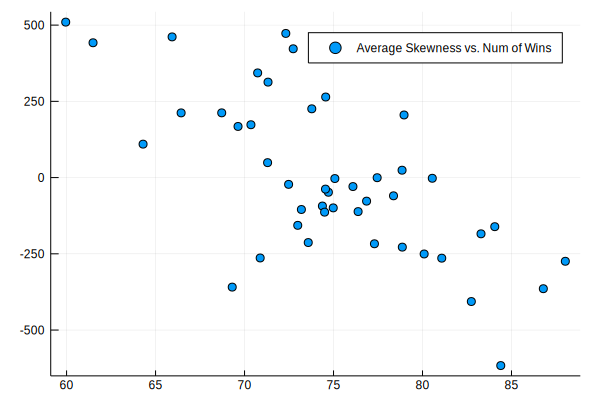

In [146]:
plot(avgNumOfWins[:, 1], avgSkew[:, 1], seriestype=:scatter, label = "Average Skewness vs. Num of Wins")

## Kurtosis

This is one where not only does it not matter a whole lot for team decision making, but it is also not an incredibly well known statistical measure. Basically, kurtosis means the contribution from the tails (the part of the distribution not at the center). The Wikipedia articles on all of these statistical measures are pretty in-depth and can let you know anything you want to about how they work. I'm including these here because I think its interesting, and the teams' distributions at either ends are a rather interesting shape as well.

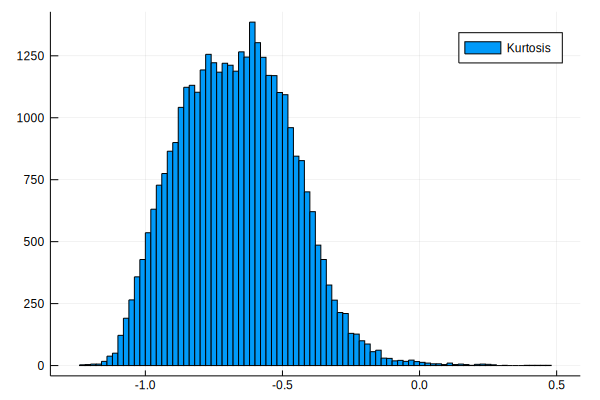

In [148]:
histogram(summaryStats[:, 5], label = "Kurtosis")

In [95]:
sumStatsKurtosis = sortslices(summaryStats, by=x->x[5], dims = 1, rev = false)

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = pvpokeRanks[Int(sumStatsKurtosis[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = pvpokeRanks[Int(sumStatsKurtosis[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = pvpokeRanks[Int(sumStatsKurtosis[i, 8])]["speciesName"]
end

sumStatsKurtosis = hcat(sumStatsKurtosis, names1)
sumStatsKurtosis = hcat(sumStatsKurtosis, names2)
sumStatsKurtosis = hcat(sumStatsKurtosis, names3)

sumStatsKurtosis = DataFrame(sumStatsKurtosis)

rename!(sumStatsKurtosis, Symbol("x1")=>Symbol("Num of Wins")); rename!(sumStatsKurtosis, Symbol("x2")=>Symbol("Avg Score")); rename!(sumStatsKurtosis, Symbol("x3")=>Symbol("Avg Variance")); rename!(sumStatsKurtosis, Symbol("x4")=>Symbol("Avg Skew")); rename!(sumStatsKurtosis, Symbol("x5")=>Symbol("Avg Kurt")); rename!(sumStatsKurtosis, Symbol("x6")=>Symbol("Rank Mon 1")); rename!(sumStatsKurtosis, Symbol("x7")=>Symbol("Rank Mon 2")); rename!(sumStatsKurtosis, Symbol("x8")=>Symbol("Rank Mon 3")); rename!(sumStatsKurtosis, Symbol("x9")=>Symbol("Mon 1")); rename!(sumStatsKurtosis, Symbol("x10")=>Symbol("Mon 2")); rename!(sumStatsKurtosis, Symbol("x11")=>Symbol("Mon 3"))

,Num of Wins,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,15421.0,1417.38,1.9472e5,0.174295,-1.23941,28.0,27.0,43.0,Charmeleon,Castform (Snowy),Lanturn
2,15430.0,1427.76,1.63629e5,0.150921,-1.23034,28.0,19.0,43.0,Charmeleon,Muk,Lanturn
3,16080.0,1466.09,1.71542e5,0.134519,-1.22121,28.0,19.0,32.0,Charmeleon,Muk,Castform (Rainy)
4,16578.0,1509.08,1.37536e5,0.189044,-1.2183,28.0,7.0,13.0,Charmeleon,Lapras,Shelgon
5,16085.0,1476.74,1.90377e5,0.14787,-1.21764,28.0,15.0,32.0,Charmeleon,Drapion,Castform (Rainy)
6,16047.0,1469.78,1.42797e5,0.211273,-1.20327,28.0,13.0,38.0,Charmeleon,Shelgon,Sealeo
7,15472.0,1438.56,181738.0,0.165605,-1.20248,28.0,15.0,43.0,Charmeleon,Drapion,Lanturn
8,16719.0,1512.16,1.67334e5,0.15671,-1.19585,28.0,15.0,20.0,Charmeleon,Drapion,Banette
9,16500.0,1494.69,1.30461e5,0.155732,-1.19412,28.0,7.0,19.0,Charmeleon,Lapras,Muk


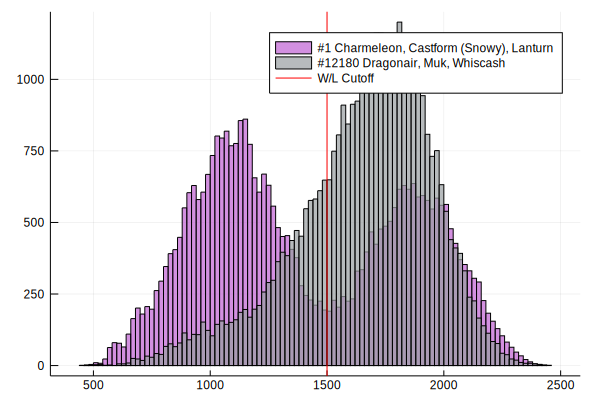

In [147]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsKurtosis[1, 6]), Int(sumStatsKurtosis[1, 7]), Int(sumStatsKurtosis[1, 8])]),:], bins = 100, color = poison, label = "#1 " * sumStatsKurtosis[1, 9] * ", " * sumStatsKurtosis[1, 10] * ", " * sumStatsKurtosis[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsKurtosis[numTeams, 6]), Int(sumStatsKurtosis[numTeams, 7]), Int(sumStatsKurtosis[numTeams, 8])]),:], bins = 100, color = normal, label = "#12180 " * sumStatsKurtosis[numTeams, 9] * ", " * sumStatsKurtosis[numTeams, 10] * ", " * sumStatsKurtosis[numTeams, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

In [97]:
avgKurt = zeros(numMons, 2)
i = 1
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        avgKurt[mon1, 1] += summaryStats[i, 5]
        avgKurt[mon2, 1] += summaryStats[i, 5]
        avgKurt[mon3, 1] += summaryStats[i, 5]
        i += 1
    end
end
for i = 1:numMons
    avgKurt[i, 2] = i
end
avgKurt[:, 1] ./ (numTeams / (numMons / 3.0))

avgKurtSorted = sortslices(avgKurt, by=x->x[1], dims = 1, rev = true)

nameAvgKurt = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameAvgKurt[i, 1] = pvpokeRanks[Int(avgKurtSorted[i, 2])]["speciesName"]
end

avgKurtSorted = hcat(avgKurtSorted, nameAvgKurt)

avgKurtSorted = DataFrame(avgKurtSorted)

rename!(avgKurtSorted, Symbol("x1")=>Symbol("Avg Kurtosis"))
rename!(avgKurtSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgKurtSorted, Symbol("x3")=>Symbol("Name"))

,Avg Kurtosis,Rank,Name
,Any,Any,Any
1,-935.125,5.0,Swampert
2,-1072.84,21.0,Typhlosion
3,-1084.08,3.0,Meganium
4,-1114.61,1.0,Venusaur
5,-1155.48,31.0,Sceptile
6,-1166.82,16.0,Blaziken
7,-1202.72,41.0,Grotle
8,-1208.2,10.0,Ivysaur
9,-1216.6,4.0,Charizard


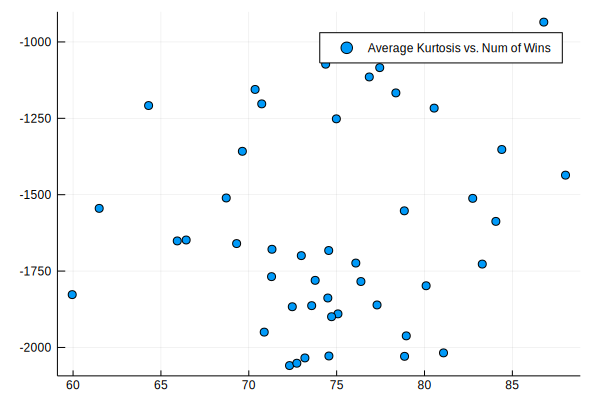

In [149]:
plot(avgNumOfWins[:, 1], avgKurt[:, 1], seriestype=:scatter, label = "Average Kurtosis vs. Num of Wins")

# Teams of Six

I'm still in the process of developing this, but for my inital team of six investigation, I'm using an algorithm that chooses the best team of three from that team of six against any team of three.

In [99]:
function maxScore(team)
    maxScores = zeros(numTeams)
    for lead = 1:6, second = 1:5, third = second + 1:6
        if(lead != second && lead != third) && !isRestricted(Int(team[Int(lead)]), Int(team[Int(second)]), Int(team[Int(third)]))
            for i = 1:numTeams
                currentScore = teamBattles[Int(teamNumber[Int(team[Int(lead)]), Int(team[Int(second)]), Int(team[Int(third)])]),i]
                if maxScores[Int(i)] < currentScore
                    maxScores[Int(i)] = currentScore
                end
            end
        end
    end
    return maxScores
end;

Here I compare the top six mons by number of wins and average score (they happen to be the same in this ranking, but in different order), the top six ranked PvPoke mons, the bottom six (of the top 30) PvPoke mons, and the bottom six mons ranked by number of wins

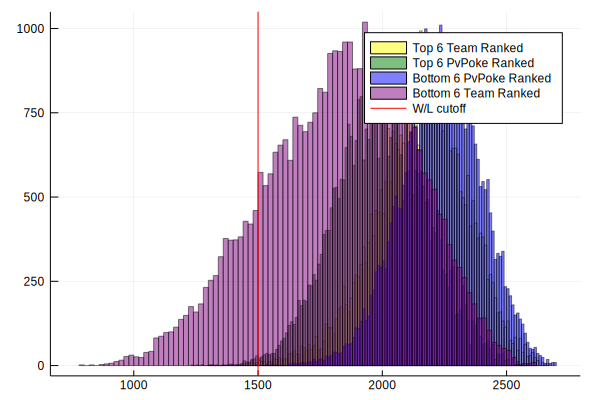

In [150]:
topSix = sort(avgNumOfWinsSorted[1:6, 2])
bottomSix = sort(avgNumOfWinsSorted[(numMons - 5):numMons, 2])

histogram(maxScore([Int(topSix[1]) Int(topSix[2]) Int(topSix[3]) Int(topSix[4]) Int(topSix[5]) Int(topSix[6]) ]), alpha = 0.5, bins = 150, color = :yellow, label = "Top 6 Team Ranked")
histogram!(maxScore([1 2 3 4 5 6]), alpha = 0.5, bins = 150, color = :green, label = "Top 6 PvPoke Ranked")
histogram!(maxScore([25 26 27 28 29 30]), alpha = 0.5, bins = 150, color = :blue, label = "Bottom 6 PvPoke Ranked")
histogram!(maxScore([Int(bottomSix[1]) Int(bottomSix[2]) Int(bottomSix[3]) Int(bottomSix[4]) Int(bottomSix[5]) Int(bottomSix[6]) ]), alpha = 0.5, bins = 150, color = :purple, label = "Bottom 6 Team Ranked")
vline!([1500], color = :red, label = "W/L cutoff")

Here is a histogram of all of the three mon teams (there are sixty) from the top team-ranked six mons, all plotted together. There's a lot going on here, so I'm going to break it down a bit further.

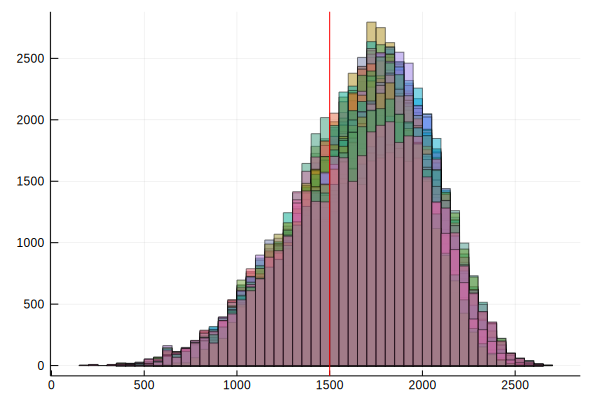

In [151]:
team = [Int(topSix[1]) Int(topSix[2]) Int(topSix[3]) Int(topSix[4]) Int(topSix[5]) Int(topSix[6]) ]
h = histogram(legend = false, alpha = 0.001)
summaryStats2 = zeros(60, 8)
p = x -> (x > 1500.0)
i = 1
for lead = 1:6, second = 1:5, third = second + 1:6
    if(lead != second && lead != third)  && !isRestricted(Int(team[Int(lead)]), Int(team[Int(second)]), Int(team[Int(third)]))
        team1 = teamBattles[Int(teamNumber[Int(team[lead]), Int(team[second]), Int(team[third])]),:]
        numWins = count(p,team1)
        summaryStats2[i, :] = [numWins mean(team1) var(team1) skewness(team1) kurtosis(team1) team[lead] team[second] team[third]]
        i += 1
        histogram!(h, teamBattles[Int(teamNumber[Int(team[lead]), Int(team[second]), Int(team[third])]),:], bins = 50, alpha = 0.5, label = team[lead])
    end
end    
h
vline!([1500], color = :red)

Here are the top teams of three from the six mon team entered above in order of number of wins

In [102]:
sumStatsTeam = sortslices(summaryStats2, by=x->x[1], dims = 1, rev = true)

names1 = Array{String}(undef, 60, 1)
for i = 1:60
    names1[i, 1] = pvpokeRanks[Int(sumStatsTeam[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, 60, 1)
for i = 1:60
    names2[i, 1] = pvpokeRanks[Int(sumStatsTeam[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, 60, 1)
for i = 1:60
    names3[i, 1] = pvpokeRanks[Int(sumStatsTeam[i, 8])]["speciesName"]
end

sumStatsTeam = hcat(sumStatsTeam, names1)
sumStatsTeam = hcat(sumStatsTeam, names2)
sumStatsTeam = hcat(sumStatsTeam, names3)

sumStatsTeam = DataFrame(sumStatsTeam)

rename!(sumStatsTeam, Symbol("x1")=>Symbol("Num of Wins")); rename!(sumStatsTeam, Symbol("x2")=>Symbol("Avg Score")); rename!(sumStatsTeam, Symbol("x3")=>Symbol("Avg Variance")); rename!(sumStatsTeam, Symbol("x4")=>Symbol("Avg Skew")); rename!(sumStatsTeam, Symbol("x5")=>Symbol("Avg Kurt")); rename!(sumStatsTeam, Symbol("x6")=>Symbol("Rank Mon 1")); rename!(sumStatsTeam, Symbol("x7")=>Symbol("Rank Mon 2")); rename!(sumStatsTeam, Symbol("x8")=>Symbol("Rank Mon 3")); rename!(sumStatsTeam, Symbol("x9")=>Symbol("Mon 1")); rename!(sumStatsTeam, Symbol("x10")=>Symbol("Mon 2")); rename!(sumStatsTeam, Symbol("x11")=>Symbol("Mon 3"))

,Num of Wins,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,27982.0,1695.06,70375.8,-0.27595,-0.20201,2.0,7.0,20.0,Dragonair,Lapras,Banette
2,27938.0,1725.05,99749.6,-0.51737,-0.0458774,2.0,5.0,7.0,Dragonair,Swampert,Lapras
3,27837.0,1691.12,85885.9,-0.544382,0.192334,2.0,7.0,22.0,Dragonair,Lapras,Whiscash
4,27677.0,1731.45,1.09189e5,-0.426449,-0.148006,2.0,5.0,20.0,Dragonair,Swampert,Banette
5,27208.0,1700.87,97062.4,-0.4341,-0.0290169,2.0,20.0,22.0,Dragonair,Banette,Whiscash
6,27185.0,1702.2,1.04735e5,-0.502152,-0.143036,7.0,2.0,5.0,Lapras,Dragonair,Swampert
7,27060.0,1676.92,92706.4,-0.550776,0.0339836,7.0,2.0,22.0,Lapras,Dragonair,Whiscash
8,26994.0,1709.02,1.12321e5,-0.423142,-0.142841,20.0,2.0,5.0,Banette,Dragonair,Swampert
9,26931.0,1680.01,86151.9,-0.386605,-0.0720598,2.0,7.0,30.0,Dragonair,Lapras,Politoed


And here's the best and worst from among that lot.

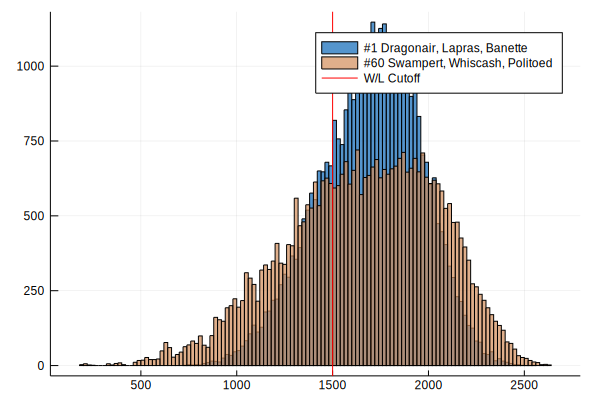

In [163]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsTeam[1, 6]), Int(sumStatsTeam[1, 7]), Int(sumStatsTeam[1, 8])]),:], bins = 100, color = dragon, label = "#1 " * sumStatsTeam[1, 9] * ", " * sumStatsTeam[1, 10] * ", " * sumStatsTeam[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsTeam[60, 6]), Int(sumStatsTeam[60, 7]), Int(sumStatsTeam[60, 8])]),:], bins = 200, color = ground, label = "#60 " * sumStatsTeam[60, 9] * ", " * sumStatsTeam[60, 10] * ", " * sumStatsTeam[60, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

And then here's the same thing, but sorted by average score.

In [104]:
sumStatsTeam2 = sortslices(summaryStats2, by=x->x[2], dims = 1, rev = true)

names1 = Array{String}(undef, 60, 1)
for i = 1:60
    names1[i, 1] = pvpokeRanks[Int(sumStatsTeam2[i, 6])]["speciesName"]
end

names2 = Array{String}(undef, 60, 1)
for i = 1:60
    names2[i, 1] = pvpokeRanks[Int(sumStatsTeam2[i, 7])]["speciesName"]
end

names3 = Array{String}(undef, 60, 1)
for i = 1:60
    names3[i, 1] = pvpokeRanks[Int(sumStatsTeam2[i, 8])]["speciesName"]
end

sumStatsTeam2 = hcat(sumStatsTeam2, names1)
sumStatsTeam2 = hcat(sumStatsTeam2, names2)
sumStatsTeam2 = hcat(sumStatsTeam2, names3)

sumStatsTeam2 = DataFrame(sumStatsTeam2)

rename!(sumStatsTeam2, Symbol("x1")=>Symbol("Num of Wins")); rename!(sumStatsTeam2, Symbol("x2")=>Symbol("Avg Score")); rename!(sumStatsTeam2, Symbol("x3")=>Symbol("Avg Variance")); rename!(sumStatsTeam2, Symbol("x4")=>Symbol("Avg Skew")); rename!(sumStatsTeam2, Symbol("x5")=>Symbol("Avg Kurt")); rename!(sumStatsTeam2, Symbol("x6")=>Symbol("Rank Mon 1")); rename!(sumStatsTeam2, Symbol("x7")=>Symbol("Rank Mon 2")); rename!(sumStatsTeam2, Symbol("x8")=>Symbol("Rank Mon 3")); rename!(sumStatsTeam2, Symbol("x9")=>Symbol("Mon 1")); rename!(sumStatsTeam2, Symbol("x10")=>Symbol("Mon 2")); rename!(sumStatsTeam2, Symbol("x11")=>Symbol("Mon 3"))

,Num of Wins,Avg Score,Avg Variance,Avg Skew,Avg Kurt,Rank Mon 1,Rank Mon 2,Rank Mon 3,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,27677.0,1731.45,1.09189e5,-0.426449,-0.148006,2.0,5.0,20.0,Dragonair,Swampert,Banette
2,27938.0,1725.05,99749.6,-0.51737,-0.0458774,2.0,5.0,7.0,Dragonair,Swampert,Lapras
3,26994.0,1709.02,1.12321e5,-0.423142,-0.142841,20.0,2.0,5.0,Banette,Dragonair,Swampert
4,27185.0,1702.2,1.04735e5,-0.502152,-0.143036,7.0,2.0,5.0,Lapras,Dragonair,Swampert
5,26304.0,1701.7,1.23956e5,-0.423864,-0.152061,2.0,5.0,22.0,Dragonair,Swampert,Whiscash
6,27208.0,1700.87,97062.4,-0.4341,-0.0290169,2.0,20.0,22.0,Dragonair,Banette,Whiscash
7,25633.0,1700.59,1.30873e5,-0.396294,-0.507099,5.0,2.0,20.0,Swampert,Dragonair,Banette
8,26160.0,1699.29,1.45241e5,-0.590727,-0.149597,22.0,2.0,5.0,Whiscash,Dragonair,Swampert
9,25852.0,1697.53,149142.0,-0.560745,-0.249432,5.0,2.0,22.0,Swampert,Dragonair,Whiscash


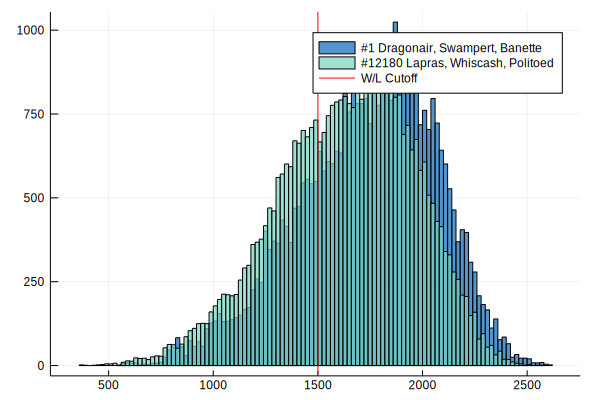

In [156]:
histogram(teamBattles[Int(teamNumber[Int(sumStatsTeam2[1, 6]), Int(sumStatsTeam2[1, 7]), Int(sumStatsTeam2[1, 8])]),:], bins = 100, color = dragon, label = "#1 " * sumStatsTeam2[1, 9] * ", " * sumStatsTeam2[1, 10] * ", " * sumStatsTeam2[1, 11])
histogram!(teamBattles[Int(teamNumber[Int(sumStatsTeam2[60, 6]), Int(sumStatsTeam2[60, 7]), Int(sumStatsTeam2[60, 8])]),:], bins = 200, color = ice, label = "#12180 " * sumStatsTeam2[60, 9] * ", " * sumStatsTeam2[60, 10] * ", " * sumStatsTeam2[60, 11])
vline!([1500], color = :red, label = "W/L Cutoff")

## Roles

### Lead

This algorithm is intended to find the best leads on average, and the table below is sorted by average score

In [174]:
leadMeanScore = zeros(numMons, 2)
leadNumWins = zeros(numMons, 2)
i = 0
p = x -> (x > 1500.0)
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        team = teamBattles[Int(teamNumber[mon1, mon2, mon3]), :]
        leadMeanScore[mon1, 1] += mean(team)
        leadNumWins[mon1, 1] += count(p, team)
        i += 1
    end
end

for j = 1:numMons
    leadMeanScore[j, 2] = j
    leadNumWins[j, 2] = j
    divisor = 0.0
    for mon2 = 1:numMons, mon3 = mon2 + 1:numMons
        if(teamNumber[j, mon2, mon3] > 0)
           divisor += 1.0
        end
    end
    leadMeanScore[j, 1] /= (divisor * numTeams)
    leadNumWins[j, 1] /= (divisor * numTeams)
end

leadScoreSorted = sortslices(leadMeanScore, by=x->x[1], dims = 1, rev = true)

nameLeads = Array{String}(undef, numMons, 1)
for j = 1:numMons
    nameLeads[j, 1] = pvpokeRanks[Int(leadScoreSorted[j, 2])]["speciesName"]
end

leadScoreSorted = hcat(leadScoreSorted, nameLeads)

45×3 Array{Any,2}:
 0.0444678   2.0  "Dragonair"       
 0.043734    5.0  "Swampert"        
 0.0433991  20.0  "Banette"         
 0.0432381   7.0  "Lapras"          
 0.0431142  22.0  "Whiscash"        
 0.0430615  30.0  "Politoed"        
 0.0426166   4.0  "Charizard"       
 0.0425851  45.0  "Relicanth"       
 0.042367   32.0  "Castform (Rainy)"
 0.0422097   9.0  "Haunter"         
 0.0421767  17.0  "Flygon"          
 0.0420628  36.0  "Sudowoodo"       
 0.0419342  16.0  "Blaziken"        
 ⋮                                  
 0.0403311   8.0  "Venomoth"        
 0.0401567  19.0  "Muk"             
 0.0400832  31.0  "Sceptile"        
 0.0400225  28.0  "Charmeleon"      
 0.039942   23.0  "Torkoal"         
 0.0396151  14.0  "Froslass"        
 0.0392464  42.0  "Cradily"         
 0.0390691  33.0  "Beedrill"        
 0.0389924  26.0  "Piloswine"       
 0.0385234  10.0  "Ivysaur"         
 0.0378549  35.0  "Dustox"          
 0.0376482  34.0  "Wormadam (Plant)"

Same thing, but sorted by number of wins

In [175]:
leadNumWinsSorted = sortslices(leadNumWins, by=x->x[1], dims = 1, rev = true)

nameLeads2 = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameLeads2[i, 1] = pvpokeRanks[Int(leadNumWinsSorted[i, 2])]["speciesName"]
end

leadNumWinsSorted = hcat(leadNumWinsSorted, nameLeads2)

45×3 Array{Any,2}:
 0.662212   2.0  "Dragonair"       
 0.608841   5.0  "Swampert"        
 0.601944  20.0  "Banette"         
 0.600744  30.0  "Politoed"        
 0.60054    7.0  "Lapras"          
 0.600207  22.0  "Whiscash"        
 0.566196  32.0  "Castform (Rainy)"
 0.563969  45.0  "Relicanth"       
 0.551282  36.0  "Sudowoodo"       
 0.544512   4.0  "Charizard"       
 0.544483  15.0  "Drapion"         
 0.544053   9.0  "Haunter"         
 0.536384  16.0  "Blaziken"        
 ⋮                                 
 0.443218  39.0  "Weepinbell"      
 0.442506  28.0  "Charmeleon"      
 0.440816   8.0  "Venomoth"        
 0.438308  31.0  "Sceptile"        
 0.438099  24.0  "Victreebel"      
 0.430043  41.0  "Grotle"          
 0.424351  14.0  "Froslass"        
 0.405874  26.0  "Piloswine"       
 0.403546  10.0  "Ivysaur"         
 0.389587  33.0  "Beedrill"        
 0.363608  34.0  "Wormadam (Plant)"
 0.343663  35.0  "Dustox"          

### Secondary

Here I'm looking at the other role in this model, the non-lead (or secondary) mon. As before, this first table is sorted by average score

In [176]:
secondaryMeanScore = zeros(numMons, 2)
secondaryNumWins = zeros(numMons, 2)
i = 0
p = x -> (x > 1500.0)
for mon1 = 1:numMons , mon2 = 1:(numMons - 1) , mon3 = (mon2 + 1):numMons
    if mon1 != mon2 && mon1 != mon3 && !isRestricted(mon1, mon2, mon3)
        team = teamBattles[Int(teamNumber[mon1, mon2, mon3]), :]
        secondaryMeanScore[mon2, 1] += mean(team)
        secondaryMeanScore[mon3, 1] += mean(team)
        secondaryNumWins[mon2, 1] += count(p, team)
        secondaryNumWins[mon3, 1] += count(p, team)
        i += 1
    end
end
for j = 1:numMons
    secondaryMeanScore[j, 2] = j
    secondaryNumWins[j, 2] = j
    divisor = 0.0
    for mon2 = 1:numMons, mon3 = mon2 + 1:numMons
        if(teamNumber[j, mon2, mon3] > 0)
           divisor += 1.0
        end
    end
    secondaryMeanScore[j, 1] /= (divisor * numTeams)
    secondaryNumWins[j, 1] /= (divisor * numTeams)
end

secondaryScoreSorted = sortslices(secondaryMeanScore, by=x->x[1], dims = 1, rev = true)

nameSecondary = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameSecondary[i, 1] = pvpokeRanks[Int(secondaryScoreSorted[i, 2])]["speciesName"]
end

secondaryScoreSorted = hcat(secondaryScoreSorted, nameSecondary)

45×3 Array{Any,2}:
 0.0857425   5.0  "Swampert"        
 0.0852277   2.0  "Dragonair"       
 0.0847954  20.0  "Banette"         
 0.08476    17.0  "Flygon"          
 0.0845832   4.0  "Charizard"       
 0.0844412  22.0  "Whiscash"        
 0.0843056   7.0  "Lapras"          
 0.0838643  45.0  "Relicanth"       
 0.0837599  30.0  "Politoed"        
 0.0834351   9.0  "Haunter"         
 0.0833366   3.0  "Meganium"        
 0.083238   24.0  "Victreebel"      
 0.0832137  39.0  "Weepinbell"      
 ⋮                                  
 0.0812737  11.0  "Skuntank"        
 0.0812056  28.0  "Charmeleon"      
 0.0811445  43.0  "Lanturn"         
 0.0811242  37.0  "Ninetales"       
 0.0808422  14.0  "Froslass"        
 0.0805225  33.0  "Beedrill"        
 0.0799274  26.0  "Piloswine"       
 0.0796455  23.0  "Torkoal"         
 0.07956    42.0  "Cradily"         
 0.0790209  35.0  "Dustox"          
 0.0785176  10.0  "Ivysaur"         
 0.0774731  34.0  "Wormadam (Plant)"

And this list is the best secondary mons by number of wins

In [177]:
secondaryNumWinSorted = sortslices(secondaryNumWins, by=x->x[1], dims = 1, rev = true)

nameSecondary2 = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameSecondary2[i, 1] = pvpokeRanks[Int(secondaryNumWinSorted[i, 2])]["speciesName"]
end

secondaryNumWinSorted = hcat(secondaryNumWinSorted, nameSecondary2)

45×3 Array{Any,2}:
 1.12693    5.0  "Swampert"        
 1.09829    2.0  "Dragonair"       
 1.08774   22.0  "Whiscash"        
 1.07926   20.0  "Banette"         
 1.07061   17.0  "Flygon"          
 1.06648    4.0  "Charizard"       
 1.06521    7.0  "Lapras"          
 1.05765   45.0  "Relicanth"       
 1.05412   30.0  "Politoed"        
 1.03565   32.0  "Castform (Rainy)"
 1.03297    9.0  "Haunter"         
 1.03102   16.0  "Blaziken"        
 1.02882    3.0  "Meganium"        
 ⋮                                 
 0.968872  31.0  "Sceptile"        
 0.96786   27.0  "Castform (Snowy)"
 0.967009  29.0  "Glalie"          
 0.950183  28.0  "Charmeleon"      
 0.949991  14.0  "Froslass"        
 0.93972   42.0  "Cradily"         
 0.931564  23.0  "Torkoal"         
 0.929     33.0  "Beedrill"        
 0.922849  26.0  "Piloswine"       
 0.886076  35.0  "Dustox"          
 0.882414  10.0  "Ivysaur"         
 0.835416  34.0  "Wormadam (Plant)"

And finally, here I plot the secondary vs. lead number of wins, with each mon being a dot.

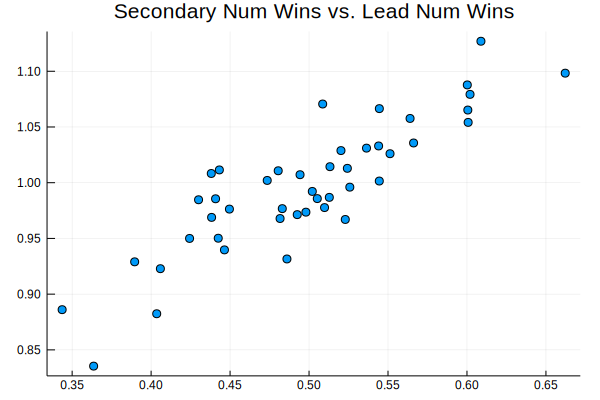

In [178]:
plot(leadNumWins[:, 1], secondaryNumWins[:, 1], seriestype=:scatter, title = "Secondary Num Wins vs. Lead Num Wins", legend = false)

## Clustering

In [131]:
kIndividual = 10
individualRanks = zeros(numMons, numMons)
for i = 1:numMons, j = 1:numMons
    individualRanks[i, j] = rankings[i, (j + 1)]
end
individualKMeans = kmeans(individualRanks, kIndividual; maxiter=200, display=:iter)
individualClusters = Array{String}(undef, kIndividual, maximum(counts(individualKMeans)))
individualAssignments = assignments(individualKMeans)
for i = 1:numMons
    for j = 1:maximum(counts(individualKMeans))
        try individualClusters[individualAssignments[i], j]
            
        catch 
            individualClusters[individualAssignments[i], j] = rankings[i, 1]
            break
        end
    end 
end
for i = 1:kIndividual, j = 1:maximum(counts(individualKMeans))
    try individualClusters[i, j]
            
    catch 
        individualClusters[i, j] = ""
    end
end
DataFrame(individualClusters)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.240709e+07
      1       2.452484e+07      -1.788225e+07 |        0
      2       2.452484e+07       0.000000e+00 |        0
K-means converged with 2 iterations (objv = 2.4524837771428585e7)


,x1,x2,x3,x4,x5,x6,x7
,String,String,String,String,String,String,String
1,Venomoth C+SW/PF,Froslass PS+A/SB,Drapion IF+C/AT,Piloswine PS+A/SE,Castform (Snowy) PS+WBI/B,Glalie IS+A/SB,Dustox C+SW/SB
2,Victreebel RL+LB/SB,Gloom RL+R/SB,Weepinbell RL+SB/SB,,,,
3,Haunter SC+SP/SB,Banette SC+SB/R,,,,,
4,Meganium VW+FP/E,Sceptile FC+LB/E,Grotle RL+BS/R,,,,
5,Venusaur VW+FP/SB,Ivysaur VW+PW/SB,Beedrill PJ+XS/SB,Wormadam (Plant) C+EB/BB,,,
6,Blastoise WG+HC/IB,Castform (Rainy) WG+WBW/T,Lanturn WG+T/HP,Relicanth WG+AT/AP,,,
7,Swampert MS+HC/E,Whiscash MS+MB/B,Politoed MS+S/E,Sudowoodo C+RS/E,,,
8,Charizard FS+BB/DC,Castform (Sunny) E+WBF/SB,Torkoal FS+E/SB,Charmeleon FF+FP/R,Ninetales FS+F/P,Houndoom S+C/F,
9,Dragonair DB+AT/R,Kingdra DB+O/HP,Skuntank PJ+C/F,Shelgon DB+F/T,Flygon MS+DC/EP,Muk PJ+TP/DP,Cradily I+GK/SE
